# Creating the Image Dataset for Instance Segmentation using YOLOv8

In [1]:
import numpy as np
from PIL import Image
from skimage import draw
import random
from pathlib import Path

def create_image(path, img_size, min_radius):
    path.parent.mkdir( parents=True, exist_ok=True )
    
    arr = np.zeros((img_size, img_size)).astype(np.uint8)
    center_x = random.randint(min_radius, (img_size-min_radius))
    center_y = random.randint(min_radius, (img_size-min_radius))
    max_radius = min(center_x, center_y, img_size - center_x, img_size - center_y)
    radius = random.randint(min_radius, max_radius)

    row_indxs, column_idxs = draw.ellipse(center_x, center_y, radius, radius, shape=arr.shape)
    
    arr[row_indxs, column_idxs] = 255

    im = Image.fromarray(arr)
    im.save(path)

def create_images(data_root_path, train_num, val_num, test_num, img_size=640, min_radius=10):
    data_root_path = Path(data_root_path)
    
    for i in range(train_num):
        create_image(data_root_path / 'train' / 'images' / f'img_{i}.png', img_size, min_radius)
        
    for i in range(val_num):
        create_image(data_root_path / 'val' / 'images' / f'img_{i}.png', img_size, min_radius)
        
    for i in range(test_num):
        create_image(data_root_path / 'test' / 'images' / f'img_{i}.png', img_size, min_radius)

create_images('datasets', train_num=120, val_num=40, test_num=40, img_size=120, min_radius=10)

* > Creating Labels

In [2]:
from rasterio import features

def create_label(image_path, label_path):
    arr = np.asarray(Image.open(image_path))

    # There may be a better way to do it, but this is what I have found so far
    cords = list(features.shapes(arr, mask=(arr >0)))[0][0]['coordinates'][0]
    label_line = '0 ' + ' '.join([f'{int(cord[0])/arr.shape[0]} {int(cord[1])/arr.shape[1]}' for cord in cords])

    label_path.parent.mkdir( parents=True, exist_ok=True )
    with label_path.open('w') as f:
        f.write(label_line)

for images_dir_path in [Path(f'datasets/{x}/images') for x in ['train', 'val', 'test']]:
    for img_path in images_dir_path.iterdir():
        label_path = img_path.parent.parent / 'labels' / f'{img_path.stem}.txt'
        label_line = create_label(img_path, label_path)

* > Creating YAML configuration file

In [3]:
yaml_content = f'''
train: train/images
val: val/images
test: test/images

names: ['circle']
    '''
    
with Path('data.yaml').open('w') as f:
    f.write(yaml_content)

In [4]:
pip install ultralytics

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 493.6 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 9.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.2 MB/s eta 0:00:00
  Attempting uninstall: wheel
    Found existing installation: wheel 0.37.1
    Uninstalling wheel-0.37.1:
      Successfully uninstalled wheel-0.37.1
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.4.60
    Uninstalling opencv-python-4.5.4.60:
      Successfully uninstalled opencv-python-4.5.4.60
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of 

In [6]:
from ultralytics import YOLO

model = YOLO("yolov8n-seg.pt")

results = model.train(
        batch=8,
        device="cpu",
        data="data.yaml",
        epochs=7,
        imgsz=120,
    )

Ultralytics YOLOv8.0.40 🚀 Python-3.7.12 torch-1.12.0+cpu CPU
yolo/engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=data.yaml, epochs=7, patience=50, batch=8, imgsz=120, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, min_memory=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, split=val, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=Fal

  0%|          | 0.00/755k [00:00<?, ?B/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.Conv                  [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.Conv                  [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.C2f                   [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.C2f                   [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

* > Labels Validation

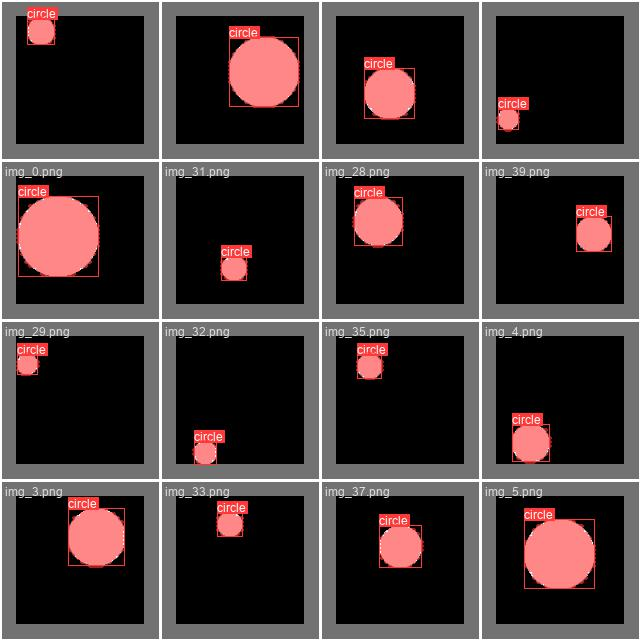

In [8]:
from IPython.display import Image as show_image
show_image(filename="runs/segment/train/val_batch0_labels.jpg")

* > Predicted validation labels

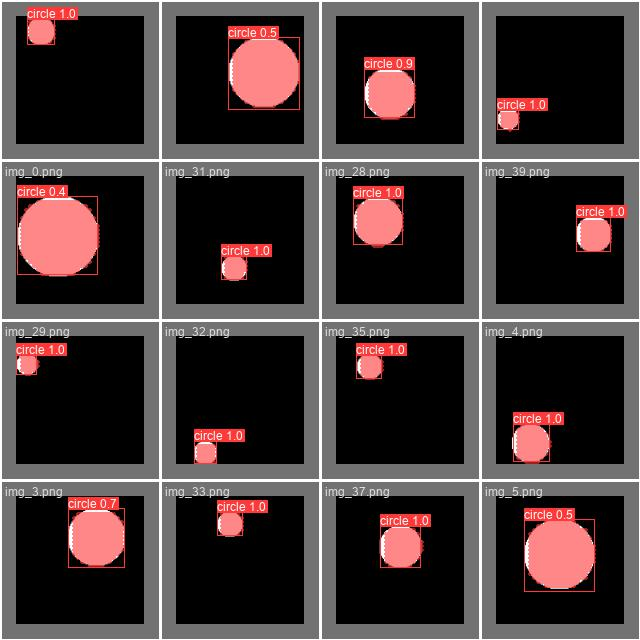

In [9]:
show_image(filename="runs/segment/train/val_batch0_pred.jpg")

* > Making Precision Curve

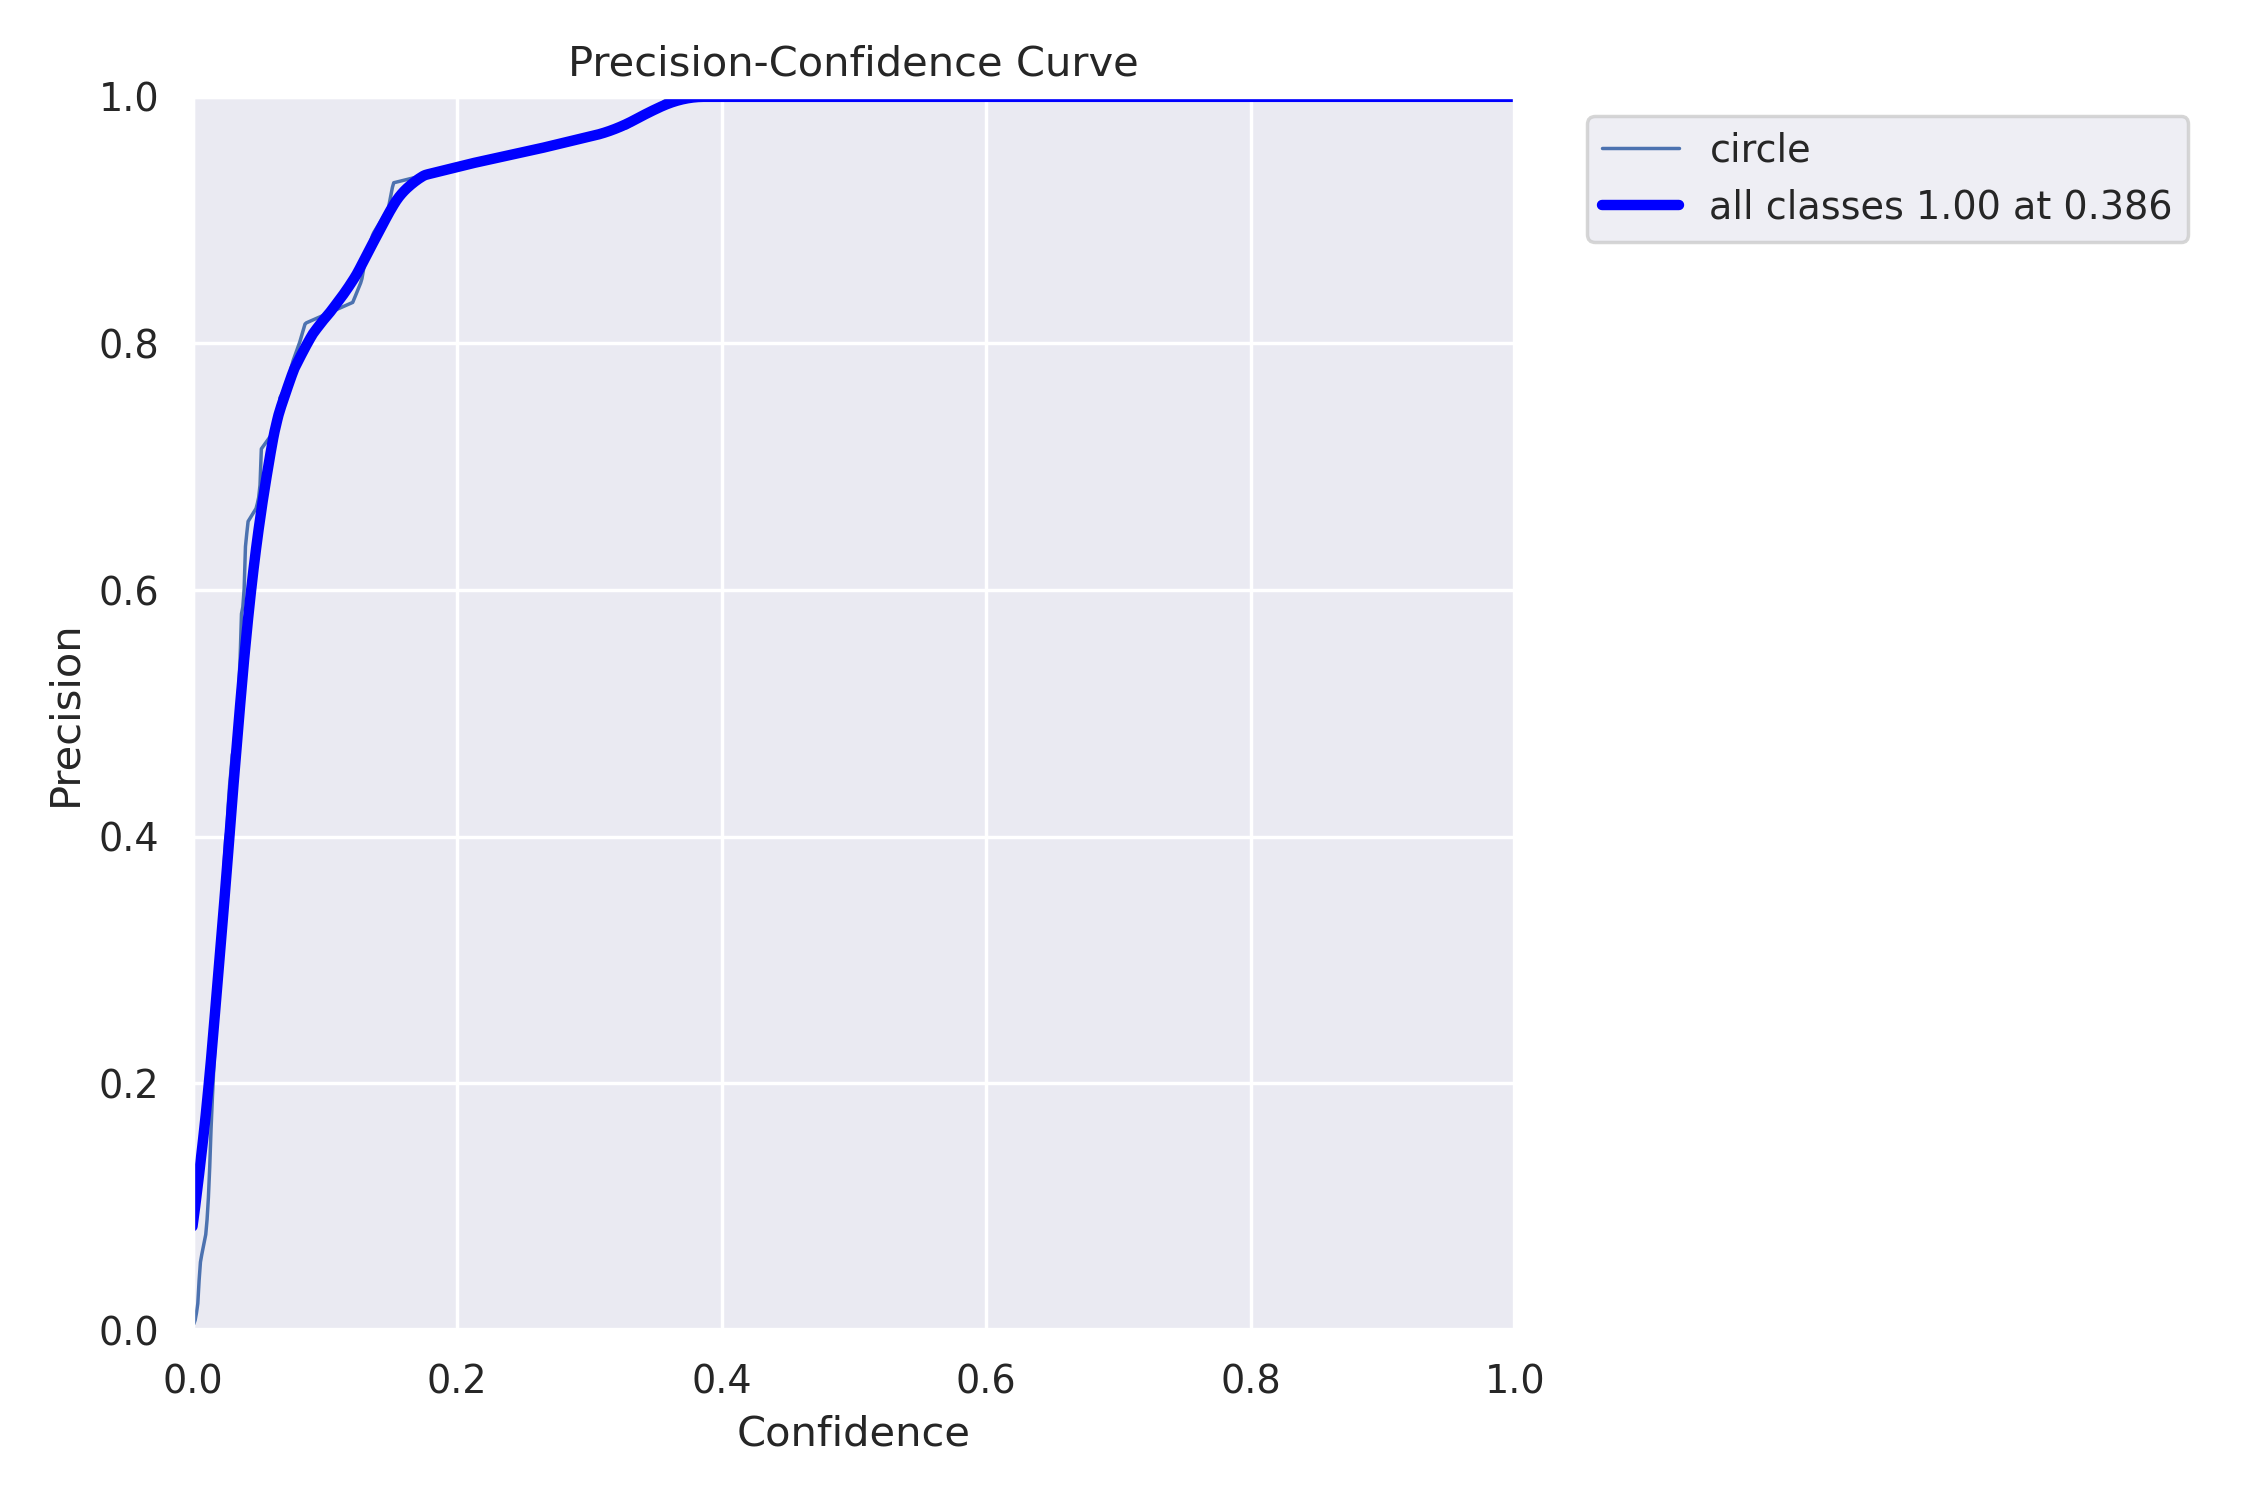

In [10]:
show_image(filename="runs/segment/train/MaskP_curve.png")

* > Recall Curve

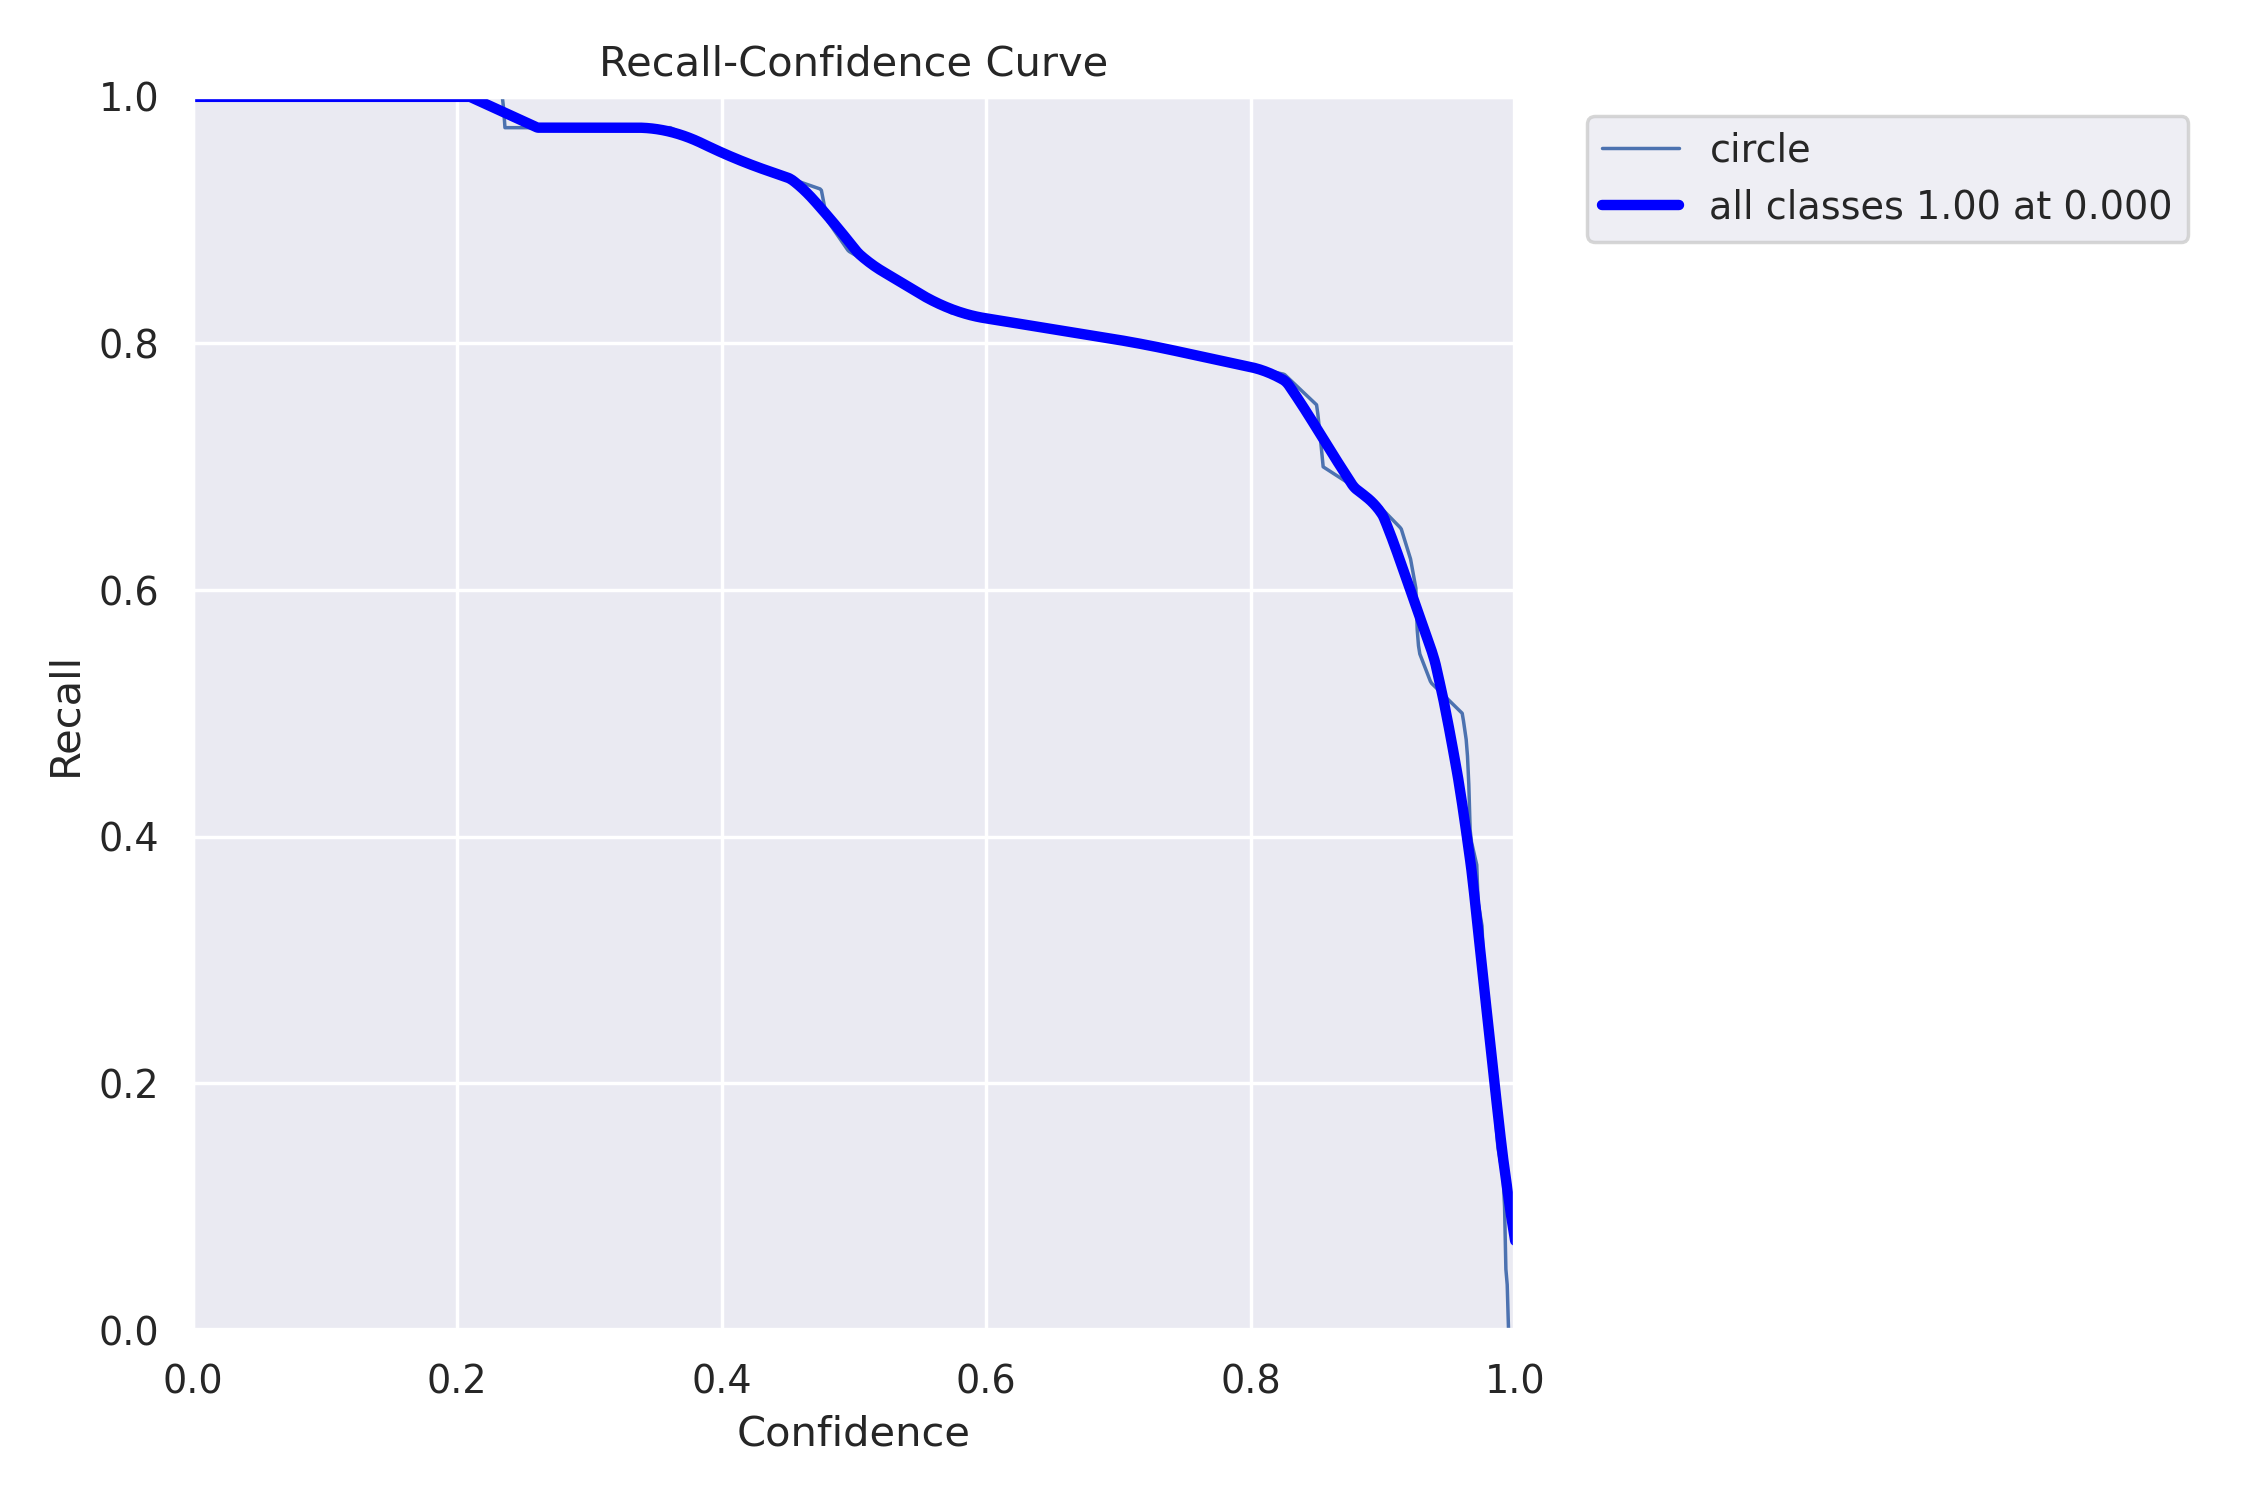

In [11]:
show_image(filename="runs/segment/train/MaskR_curve.png")

* > Precision-Recall Curve

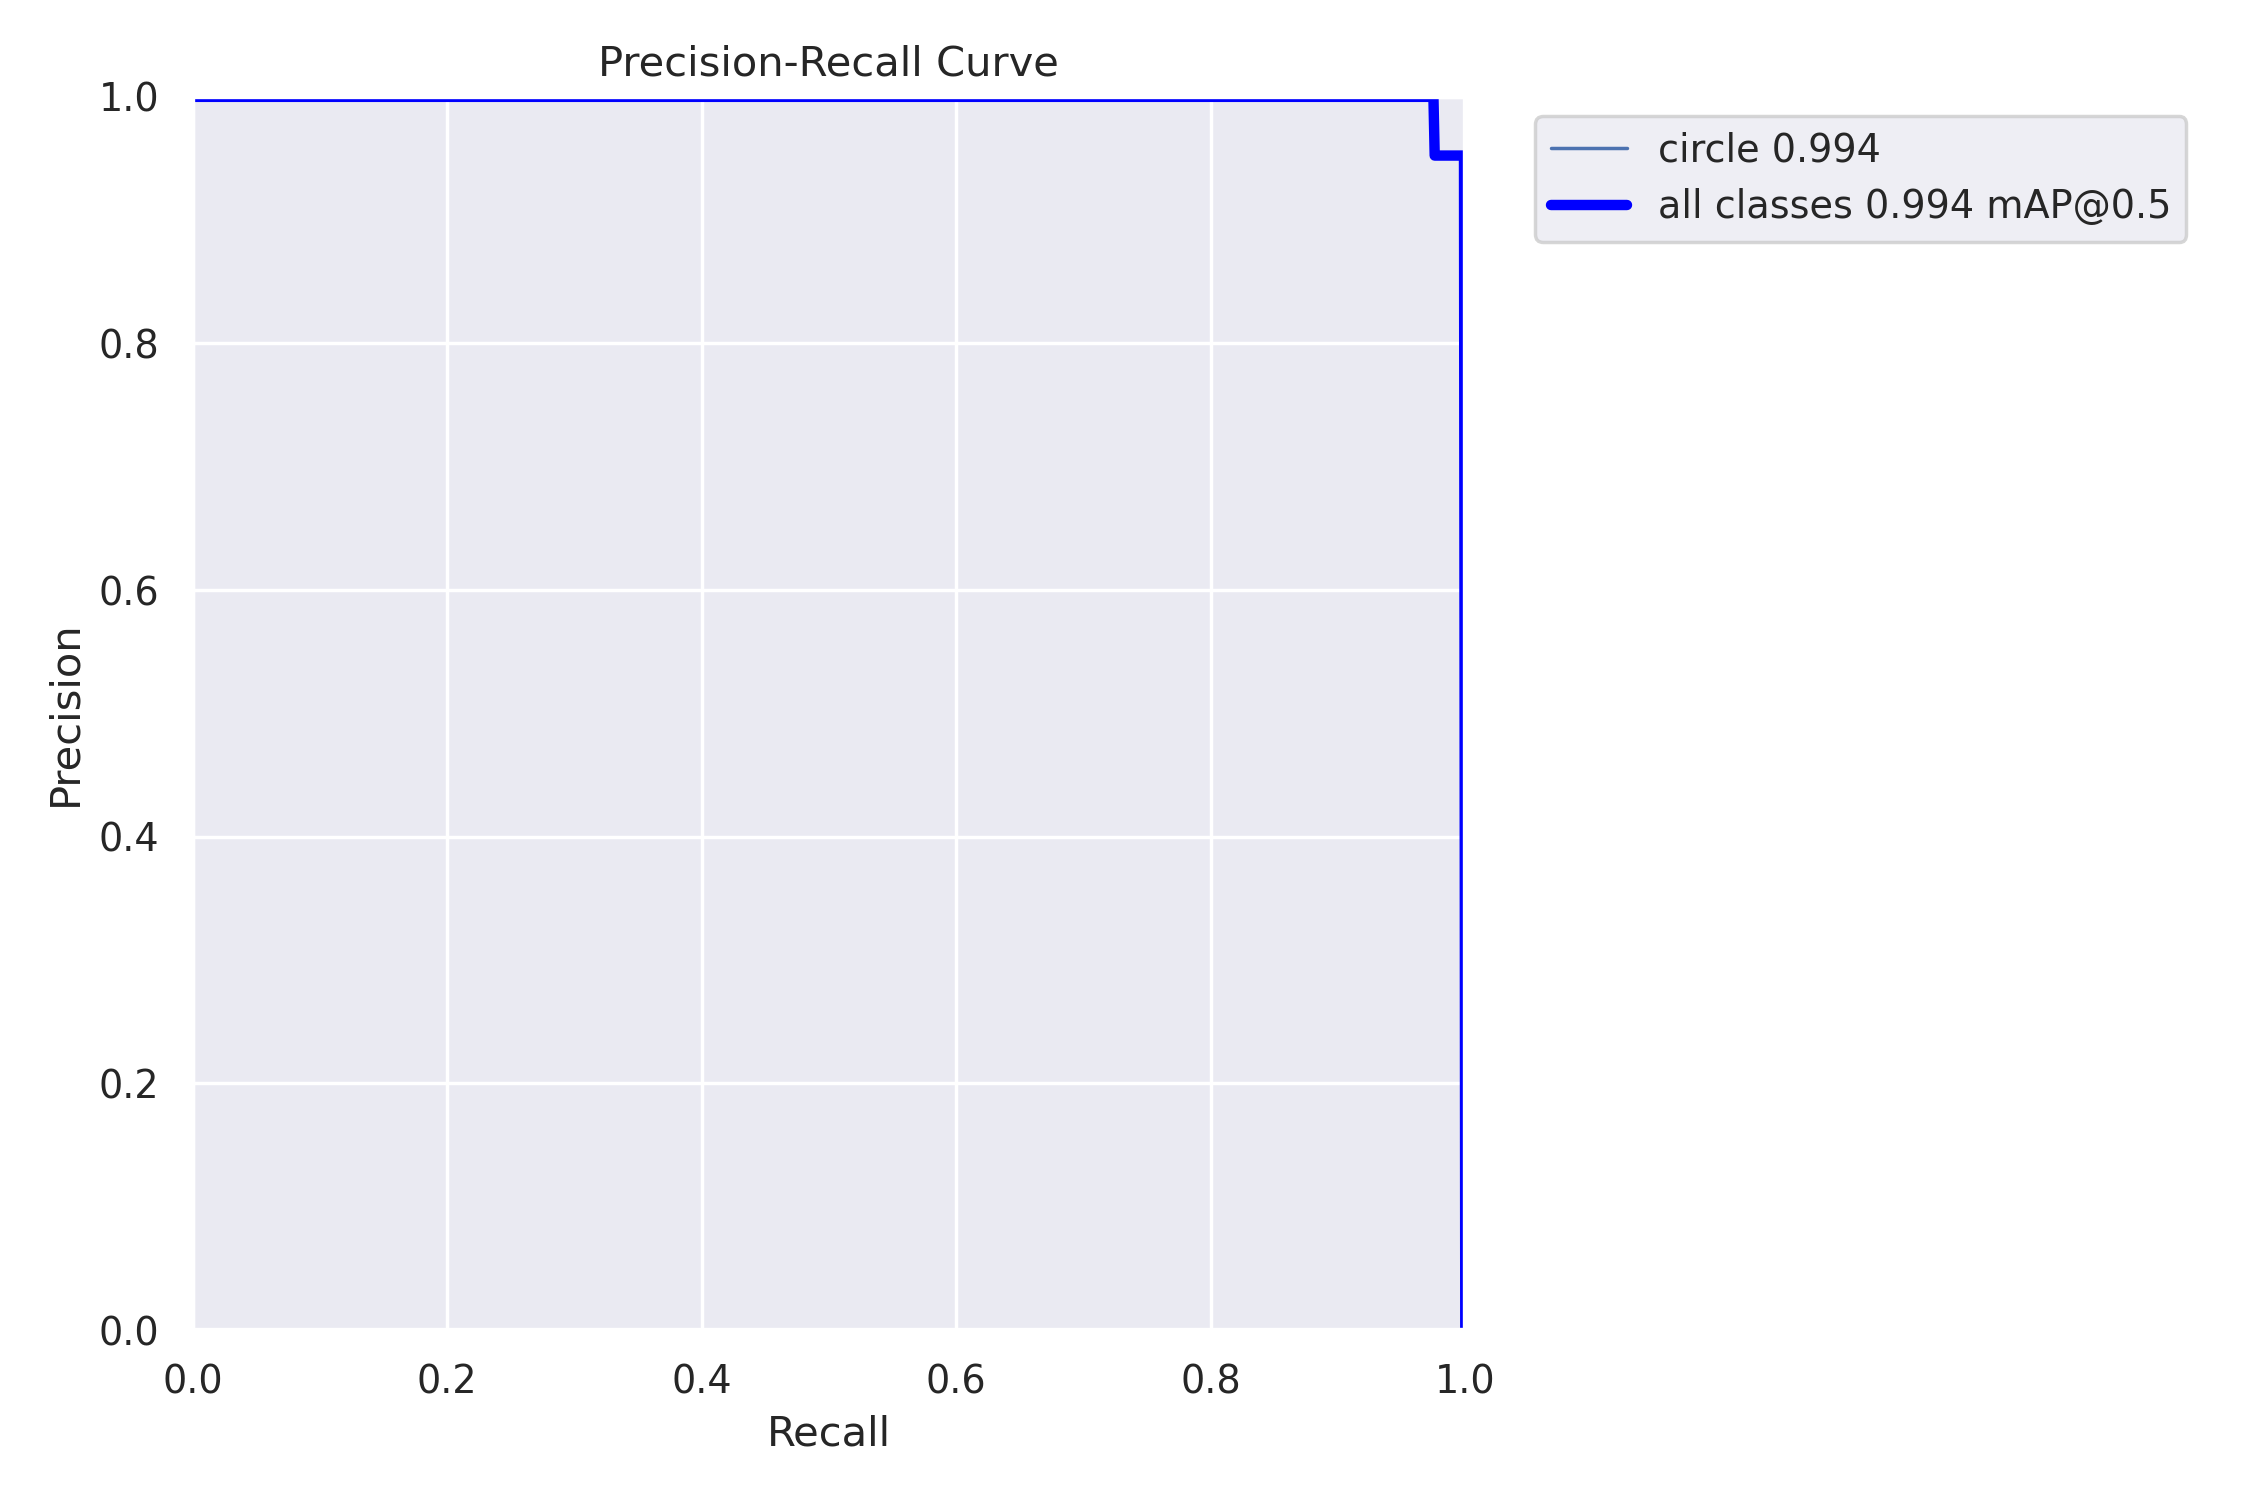

In [12]:
show_image(filename="runs/segment/train/MaskPR_curve.png")

* > Loss over Time

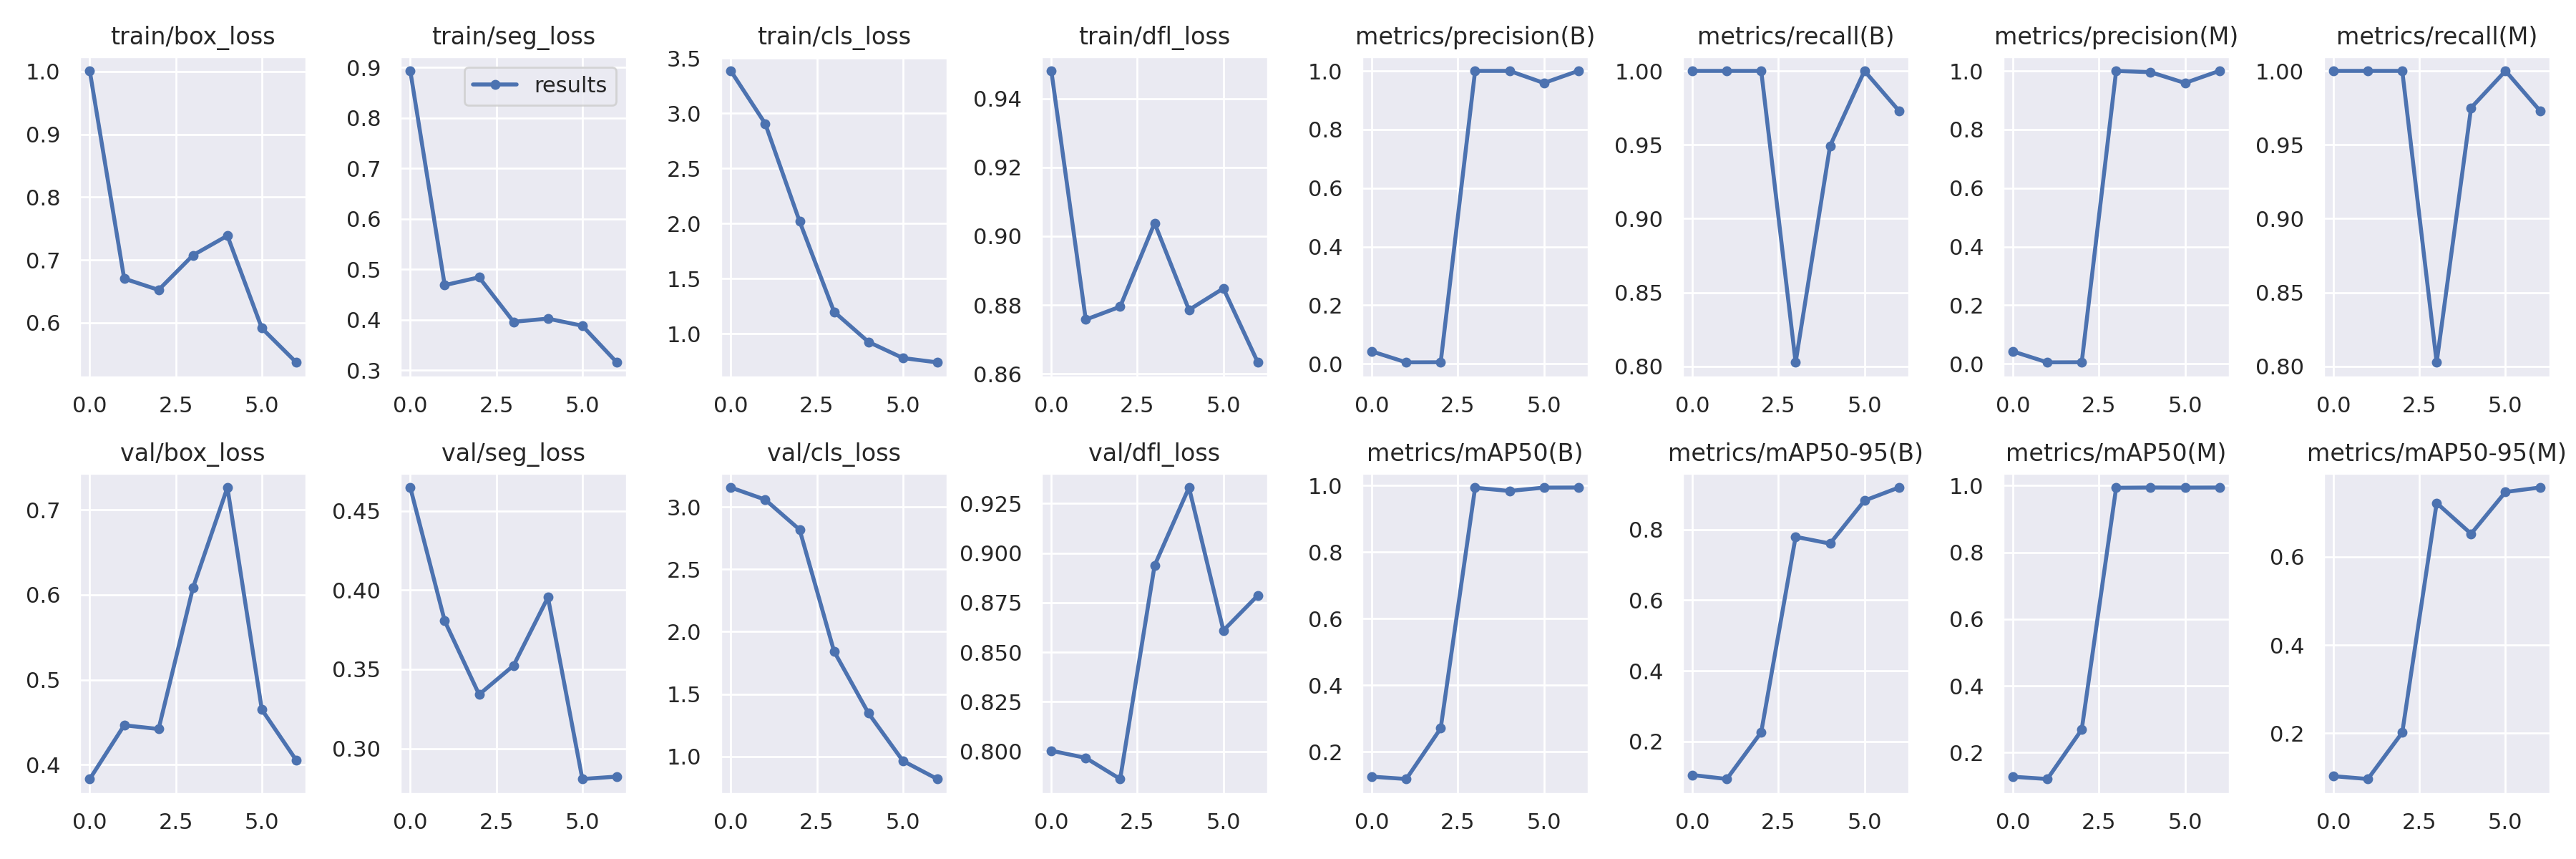

In [13]:
show_image(filename="runs/segment/train/results.png")

* > Using Trained Model

In [14]:
my_model = YOLO('runs/segment/train/weights/best.pt')
results = list(my_model('datasets/test/images/img_5.png', conf=0.128))
result = results[0]

Ultralytics YOLOv8.0.40 🚀 Python-3.7.12 torch-1.12.0+cpu CPU
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs

image 1/1 /kaggle/working/datasets/test/images/img_5.png: 128x128 1 circle, 21.4ms
Speed: 0.2ms pre-process, 21.4ms inference, 4.2ms postprocess per image at shape (1, 3, 128, 128)


In [15]:
result.masks.segments

[array([[    0.19531,     0.34375],
        [     0.1875,     0.35156],
        [     0.1875,     0.35937],
        [    0.17187,       0.375],
        [    0.16406,       0.375],
        [    0.15625,     0.38281],
        [    0.15625,     0.57812],
        [    0.16406,     0.58594],
        [    0.16406,     0.59375],
        [    0.19531,       0.625],
        [    0.20312,       0.625],
        [    0.22656,     0.64844],
        [    0.23437,     0.64844],
        [    0.24219,     0.65625],
        [       0.25,     0.65625],
        [    0.25781,     0.66406],
        [    0.25781,     0.67187],
        [    0.27344,     0.67187],
        [    0.28125,     0.67969],
        [    0.32031,     0.67969],
        [    0.32812,     0.67187],
        [    0.33594,     0.67187],
        [    0.34375,     0.66406],
        [    0.35156,     0.66406],
        [    0.35937,     0.65625],
        [    0.36719,     0.65625],
        [      0.375,     0.64844],
        [    0.39844,     0.

Second way is:

In [16]:
result.masks.masks

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

Let's see what the mask looks like:

In [21]:
import torchvision.transforms as T
T.ToPILImage()(result.masks.masks).show()

Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening '/tmp/tmpyg2miyzv.PNG'
